In [ ]:
%pip install seaborn
%pip install scikit-learn
%pip install tqdm
%pip install jax jaxlib
%pip install numpy cython
%pip install git+https://github.com/lindermanlab/ssm.git --no-build-isolation
%pip install -r requirements.txt


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/lindermanlab/ssm.git to /private/var/folders/bh/8xfnyc697wbf0xbc04k211440000gn/T/pip-r

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

import plot_models_v_mouse as bp
import model_policies as models
from sklearn.model_selection import train_test_split
import conditional_probs as cprobs
import resample_and_model_reps as reps
import model_fitting as fit

## Notebook contents: logistic regression, RFLR, HMM, FQ-learning models fit to 2ABT data
This notebook provides an overview of fitting and predicting mouse behavior in a two-armed bandit using descriptive, algorithmic, and theoretical models.


# Load in data and train-test-split

In [16]:
data = pd.read_csv(os.path.join('mouse_data.csv'))
data.head()

,Trial,blockTrial,Decision,Switch,Reward,Condition,Target,blockLength,Session,Mouse
0,11.0,11.0,1.0,0.0,1.0,90-10,1.0,58.0,m1_77,m1
1,12.0,12.0,1.0,0.0,1.0,90-10,1.0,58.0,m1_77,m1
2,13.0,13.0,1.0,0.0,1.0,90-10,1.0,58.0,m1_77,m1
3,14.0,14.0,1.0,0.0,1.0,90-10,1.0,58.0,m1_77,m1
4,15.0,15.0,1.0,0.0,1.0,90-10,1.0,58.0,m1_77,m1


In [17]:
probs='80-20' # P(high)-P(low)
seq_nback=3 # history length for conditional probabilites
train_prop=0.7 # for splitting sessions into train and test
seed = np.random.randint(1000) # set seed for reproducibility

data = data.loc[data.Condition==probs] # segment out task condition

In [18]:
data.head()

,Trial,blockTrial,Decision,Switch,Reward,Condition,Target,blockLength,Session,Mouse
106145,11.0,11.0,0.0,1.0,1.0,80-20,0.0,12.0,m1_63,m1
106146,12.0,12.0,0.0,0.0,1.0,80-20,0.0,12.0,m1_63,m1
106147,13.0,0.0,0.0,0.0,0.0,80-20,1.0,53.0,m1_63,m1
106148,14.0,1.0,0.0,0.0,0.0,80-20,1.0,53.0,m1_63,m1
106149,15.0,2.0,1.0,1.0,1.0,80-20,1.0,53.0,m1_63,m1


In [19]:
data = cprobs.add_history_cols(data, seq_nback) # set history labels up front

train_session_ids, test_session_ids = train_test_split(data.Session.unique(), 
                                                       train_size=train_prop, random_state=seed) # split full df for train/test

data['block_pos_rev'] = data['blockTrial'] - data['blockLength'] # reverse block position from transition
data['model']='mouse'
data['highPort'] = data['Decision']==data['Target'] # boolean, chose higher probability port

train_features, _, _ = reps.pull_sample_dataset(train_session_ids, data)
test_features, _, block_pos_core = reps.pull_sample_dataset(test_session_ids, data)

bpos_mouse = bp.get_block_position_summaries(block_pos_core)
bpos_mouse['condition'] = 'mouse'

In [20]:
data.head()

,Trial,blockTrial,Decision,Switch,Reward,Condition,Target,blockLength,Session,Mouse,decision_seq,reward_seq,history,RL_history,block_pos_rev,model,highPort
0,11.0,11.0,0.0,1.0,1.0,80-20,0.0,12.0,m1_63,m1,None,None,NaN,NaN,-1.0,mouse,True
1,12.0,12.0,0.0,0.0,1.0,80-20,0.0,12.0,m1_63,m1,None,None,NaN,NaN,0.0,mouse,True
2,13.0,0.0,0.0,0.0,0.0,80-20,1.0,53.0,m1_63,m1,None,None,NaN,NaN,-53.0,mouse,False
3,14.0,1.0,0.0,0.0,0.0,80-20,1.0,53.0,m1_63,m1,000,110,AAa,RRr,-52.0,mouse,False
4,15.0,2.0,1.0,1.0,1.0,80-20,1.0,53.0,m1_63,m1,000,100,Aaa,Rrr,-51.0,mouse,True


In [26]:
block_pos_core.head() # for evaluation

,Trial,blockTrial,Decision,Switch,Reward,Condition,Target,blockLength,Session,Mouse,decision_seq,reward_seq,history,RL_history,block_pos_rev,model,highPort
0,11.0,11.0,0.0,0.0,0.0,80-20,1.0,20.0,m5_63,m5,None,None,NaN,NaN,-9.0,mouse,False
1,12.0,12.0,0.0,0.0,0.0,80-20,1.0,20.0,m5_63,m5,None,None,NaN,NaN,-8.0,mouse,False
2,13.0,13.0,0.0,0.0,0.0,80-20,1.0,20.0,m5_63,m5,None,None,NaN,NaN,-7.0,mouse,False
3,14.0,14.0,0.0,0.0,0.0,80-20,1.0,20.0,m5_63,m5,000,000,aaa,rrr,-6.0,mouse,False
4,15.0,15.0,0.0,0.0,0.0,80-20,1.0,20.0,m5_63,m5,000,000,aaa,rrr,-5.0,mouse,False


In [27]:
bpos_mouse

,block_pos,phigh,phigh_std,pswitch,pswitch_std,n,condition
0,-20.0,0.841365,0.365702,0.050201,0.218579,498,mouse
1,-19.0,0.849505,0.357911,0.051485,0.221204,505,mouse
2,-18.0,0.827519,0.378164,0.058140,0.234234,516,mouse
3,-17.0,0.822642,0.382333,0.060377,0.238410,530,mouse
4,-16.0,0.825603,0.379803,0.064935,0.246640,539,mouse
5,-15.0,0.828829,0.376998,0.075676,0.264717,555,mouse
6,-14.0,0.826549,0.378973,0.053097,0.224426,565,mouse
7,-13.0,0.844133,0.363047,0.066550,0.249459,571,mouse
8,-12.0,0.837329,0.369382,0.044521,0.206425,584,mouse
9,-11.0,0.842282,0.364783,0.062081,0.241504,596,mouse


# Plot conditional switch probabilities for just the mouse behavior first
Sort held out conditioned history sequences by full dataset P(switch|sequence)

In [28]:
# full dataset for sorting
df_mouse_symm_reference = cprobs.calc_conditional_probs(data, symm=True, 
                                                        action=['Switch']).sort_values('pswitch')

In [29]:
df_mouse_symm_reference

,history,pswitch,n,pswitch_err
0,AAA,0.009414,46738,0.000447
16,aAA,0.009637,11207,0.000923
8,AaA,0.015153,11879,0.001121
24,aaA,0.022311,3496,0.002498
13,AbB,0.029412,102,0.016729
21,aBB,0.033540,2743,0.003438
20,aBA,0.038462,78,0.021775
4,ABA,0.041667,24,0.040789
28,abA,0.044143,589,0.008464
29,abB,0.045255,685,0.007942


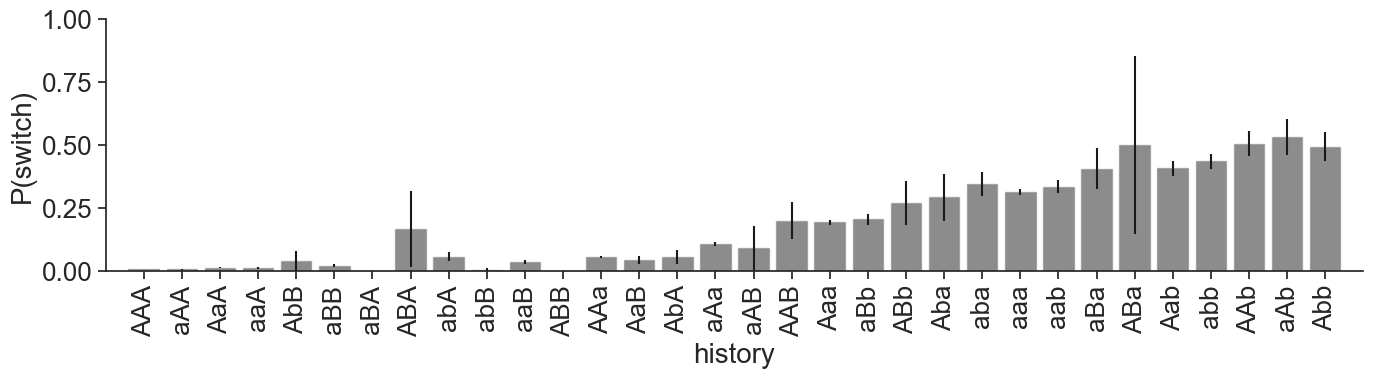

In [30]:
df_mouse_symm = cprobs.calc_conditional_probs(block_pos_core, symm=True, action=['Switch', 'Decision'])
df_mouse_symm = cprobs.sort_cprobs(df_mouse_symm, df_mouse_symm_reference.history.values)
bp.plot_sequences(df_mouse_symm, alpha=0.5) 

In [32]:
df_mouse_symm

,history,pdecision,n,pdecision_err,pswitch,pswitch_err
0,AAA,0.524711,14427,0.004158,0.007070,0.000698
16,aAA,0.513041,3489,0.008462,0.006592,0.001370
8,AaA,0.509501,3684,0.008236,0.012758,0.001849
24,aaA,0.514019,1070,0.015279,0.011215,0.003219
13,AbB,0.560000,25,0.099277,0.040000,0.039192
21,aBB,0.547963,761,0.018041,0.021025,0.005201
20,aBA,0.400000,10,0.154919,0.000000,0.000000
4,ABA,0.166667,6,0.152145,0.166667,0.152145
28,abA,0.571429,175,0.037409,0.057143,0.017546
29,abB,0.458333,192,0.035959,0.005208,0.005195


# Fit models on training data, predict choice probabilities for held-out data
Model predictions (`model_probs`) for each held out session stored for plotting below.

## Logistic regression
Fit logistic regression on training set, with coefficients for choice history (up to trial n-L1), choice-reward interaction (up to trial n-L2), and reward history (up to trial n-L3).

In [7]:
L1 = 1 # choice history
L2 =  5 # choice * reward history
L3 = 0
memories = [L1, L3, L2, 1]

lr = models.fit_logreg_policy(train_features, memories) # refit model with reduced histories, training set
model_probs = models.compute_logreg_probs(test_features, lr_args=[lr, memories])

## Recursively formulated logistic regression (RFLR)

In [8]:
params, nll = fit.fit_with_sgd(fit.log_probability_rflr, train_features) # quick fit on RFLR parameters
alpha, beta, tau = params
print(f'alpha = {alpha[0]:.2f}')
print(f'beta = {beta[0]:.2f}')
print(f'tau = {tau[0]:.2f}')

model_probs = models.RFLR(test_features, params)

iteration  0 neg ll:  0.21882264
iteration  2500 neg ll:  0.17694661
iteration  5000 neg ll:  0.17688124
iteration  7500 neg ll:  0.17687814
alpha = 0.81
beta = 2.21
tau = 1.31


## Hidden Markov model (HMM)

In [9]:
q = 0.98 # 1-p(block transition)
p = 0.8 # p(reward | high port)

model_probs = models.compute_hmm_probs(test_features, parameters={'q':q, 'p':p})

## forgetting Q-learning model (F-Q model)
Using $\alpha$, $\beta$, and $\tau$ parameters derived from fit RFLR above.

In [10]:
T = (1-np.exp(-1/tau))/beta 
k = 1-np.exp(-1/tau) 
a = alpha 

model_probs = models.fq_learning_model(test_features, parameters=[a, k, T])

# Predict action and plot
Apply policy ('greedy', 'stochastic', or 'softmax') to select actions from `model_probs` and plot behavior. Can add replicate runs for stochastic policies.

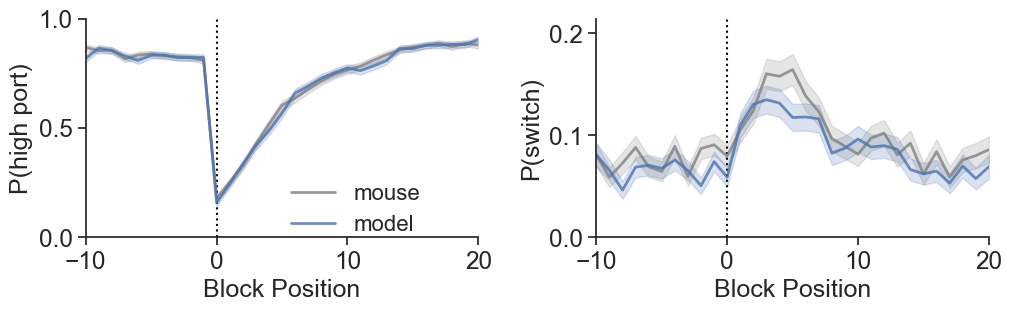

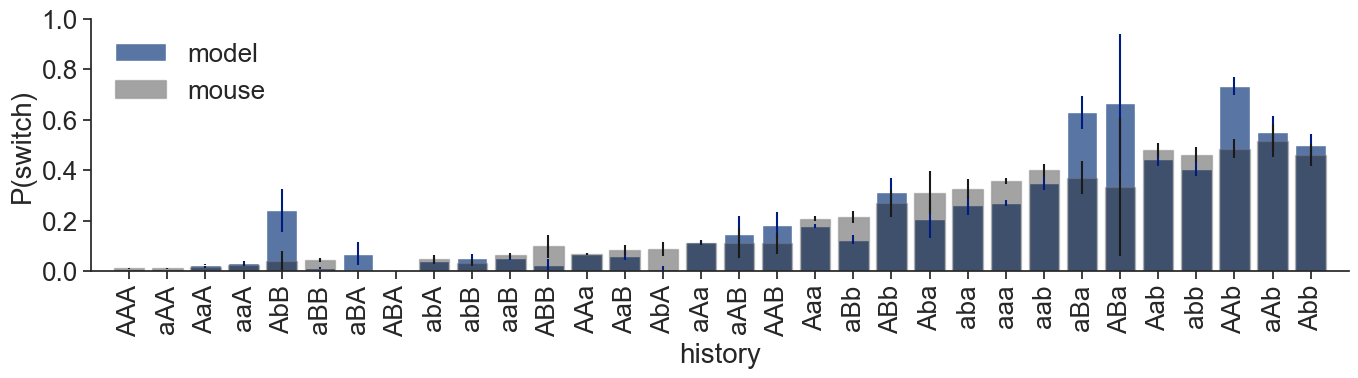

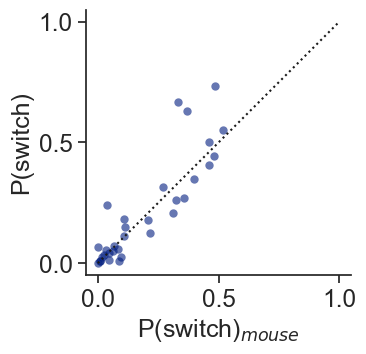

In [11]:
model_choices, model_switches = models.model_to_policy(model_probs, test_features, policy='stochastic')

block_pos_model = reps.reconstruct_block_pos(block_pos_core, model_choices, model_switches)
bpos_model = bp.get_block_position_summaries(block_pos_model)
bpos_model['condition'] = 'model' # label model predictions as such
bpos_model_v_mouse = pd.concat((bpos_mouse, bpos_model)) # agg df with model predictions and mouse data
color_dict = {'mouse': 'gray', 'model': sns.color_palette()[0]}#plot_config['model_seq_col']}
bp.plot_by_block_position(bpos_model_v_mouse, subset='condition', color_dict = color_dict)

symm_cprobs_model = cprobs.calc_conditional_probs(block_pos_model, symm=True, action=['Switch'])
symm_cprobs_model = cprobs.sort_cprobs(symm_cprobs_model, df_mouse_symm.history.values)
bp.plot_sequences(df_mouse_symm, overlay=symm_cprobs_model, main_label='mouse', overlay_label='model')

bp.plot_scatter(df_mouse_symm, symm_cprobs_model)